In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score,log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
import os
from tqdm import tqdm



import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("HR_comma_sep.csv")

In [3]:
X= df.drop('left', axis = 1)


In [4]:
y= df['left']

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=24,test_size=0.3,stratify=y)

In [6]:
ohe = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')
ct = make_column_transformer(('passthrough', make_column_selector(dtype_exclude=object)  ),
                             (ohe,make_column_selector(dtype_include=object)  ),
                             verbose_feature_names_out=False).set_output(transform='pandas')

0.43649681302349613


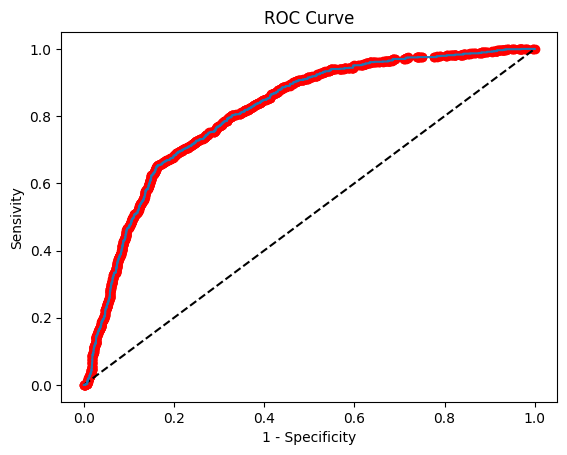

0.8108072160761836


In [7]:
lr = LogisticRegression(random_state=24)
pipe = Pipeline([('CT',ct),('SCL',None),('LR',lr)])

pipe.fit(X_train, y_train)
y_pred_prob = pipe.predict_proba(X_test)
print(log_loss(y_test, y_pred_prob))

pipe.fit(X_train, y_train)
y_pred_prob= pipe.predict_proba(X_test)
p_y_1= y_pred_prob[:,1]

m1spec, sens, thresholds = roc_curve(y_test,p_y_1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(m1spec,sens)
plt.scatter(m1spec, sens, c='red')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensivity')
plt.title('ROC Curve')
plt.show()
print(roc_auc_score(y_test, p_y_1))



kfold = StratifiedKFold(n_splits=5, random_state=24, shuffle=True)

params = {'LR__solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'], 'LR__multi_class':['ovr','multinomial'],'LR__C':np.linspace(0.001, 10, 20)}

In [18]:
#gcv = GridSearchCV(pipe, param_grid=params,scoring='roc_auc', cv=kfold, verbose=3)
gcv = GridSearchCV(pipe, param_grid=params,scoring='neg_log_loss', cv=kfold, verbose=3)

In [19]:
gcv.fit(X,y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=-0.506 total time=   0.1s
[CV 2/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=-0.514 total time=   0.1s
[CV 3/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=-0.511 total time=   0.1s
[CV 4/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=-0.512 total time=   0.1s
[CV 5/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=-0.511 total time=   0.1s
[CV 1/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=-0.523 total time=   0.0s
[CV 2/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=-0.522 total time=   0.0s
[CV 3/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=-0.519 total time=   0.0s
[CV 4/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=-0.518 total time=   0.0s
[CV 5/5] END LR__C=0.001, LR__multi_cl

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000024EDBD136E0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transfor...
       2.10605263e+00, 2.63231579e+00, 3.15857895e+00, 3.68484211e+00,
       4.21110526e+00, 4.73736842e+00, 5.26363158e+00, 5.78989474e+00,
       6.31615789e+00, 6.84242105e+00, 7.36868421e+00, 7.89494737e+00,
       8.42121053e+00, 8.94747368e+00, 9.47373684e+00, 1.00000000e+01]),
                         'LR__multi_class': ['ovr', 'multinomial'],
                         'LR__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                        'newton-cholesky', 'sag', 'saga']},
             scoring='neg_log_loss', verbose=3)

In [11]:
print(gcv.best_params_)
print(gcv.best_score_)

{'LR__C': 0.5272631578947369, 'LR__multi_class': 'ovr', 'LR__solver': 'newton-cholesky'}
0.8201244202657666


In [12]:
pd_cv= pd.DataFrame(gcv.cv_results_)
print(pd_cv.shape)

(240, 16)


In [13]:
###### Inferencing
best_model = gcv.best_estimator_

In [15]:
tst= pd.read_csv("tst_hr.csv")
print(best_model.predict(tst))

[1 0 1 0 0 0 1 0 0 0 0 0 0 0 0]


In [17]:
best_model.predict_proba(tst)

array([[0.46610114, 0.53389886],
       [0.759717  , 0.240283  ],
       [0.46567668, 0.53432332],
       [0.51617157, 0.48382843],
       [0.8600311 , 0.1399689 ],
       [0.99463038, 0.00536962],
       [0.38126618, 0.61873382],
       [0.6026863 , 0.3973137 ],
       [0.8944143 , 0.1055857 ],
       [0.93982369, 0.06017631],
       [0.95519628, 0.04480372],
       [0.85387241, 0.14612759],
       [0.79110049, 0.20889951],
       [0.95982474, 0.04017526],
       [0.86540774, 0.13459226]])

In [ ]:

#### By Sir #####

# import pandas as pd
# from sklearn.linear_model import LogisticRegression
# import numpy as np
# from sklearn.compose import make_column_transformer 
# from sklearn.compose import make_column_selector
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import log_loss
# import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.pipeline import Pipeline
# import os 
# os.chdir(r"C:\Training\Academy\Statistics (Python)\Cases\human-resources-analytics")

# hr = pd.read_csv("HR_comma_sep.csv"
# X = hr.drop('left', axis=1)
# y = hr['left']

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#         random_state=24, test_size=0.3, stratify=y)

# ohe = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')
# scaler_mm = MinMaxScaler()
# scaler_std = StandardScaler()
# ct = make_column_transformer(('passthrough', make_column_selector(dtype_exclude=object)  ),
#                              (ohe, make_column_selector(dtype_include=object) ),
#                             verbose_feature_names_out=False).set_output(transform='pandas')
# lr = LogisticRegression(random_state=24)
# pipe = Pipeline([('CT',ct),('SCL',None),('LR',lr)])

# pipe.fit(X_train, y_train)
# y_pred_prob = pipe.predict_proba(X_test)
# print(log_loss(y_test, y_pred_prob))

# #### K-FOLDS

# kfold = StratifiedKFold(n_splits=5, random_state=24, 
#                         shuffle=True)
# params = {'LR__solver':['lbfgs','liblinear',
#           'newton-cg','newton-cholesky',
#           'sag','saga'],
#           'LR__C':np.linspace(0.001, 10, 20),
#           'SCL':[scaler_mm, scaler_std, None]}
# gcv = GridSearchCV(pipe, param_grid=params,
#                    scoring='roc_auc',
#                    cv=kfold, verbose=3)
# gcv.fit(X,y)
# print(gcv.best_params_)
# print(gcv.best_score_)

# pd_cv = pd.DataFrame(gcv.cv_results_)
# print(pd_cv.shape)
